In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [47]:
profit = pd.read_csv('G2M_Case_study_finalds.csv', usecols=['Date', 'Company', 'Profit'], parse_dates=['Date'])

In [48]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Date     359392 non-null  datetime64[ns]
 1   Company  359392 non-null  object        
 2   Profit   359392 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.2+ MB


In [49]:
profit = profit.set_index('Date')

In [50]:
yellow_cab_profit = profit[profit['Company'] == 'Yellow Cab']
pink_cab_profit = profit[profit['Company'] == 'Pink Cab']

In [51]:
yellow_cab_profit_monthly = yellow_cab_profit.resample('M').mean()
pink_cab_profit_monthly = pink_cab_profit.resample('M').mean()

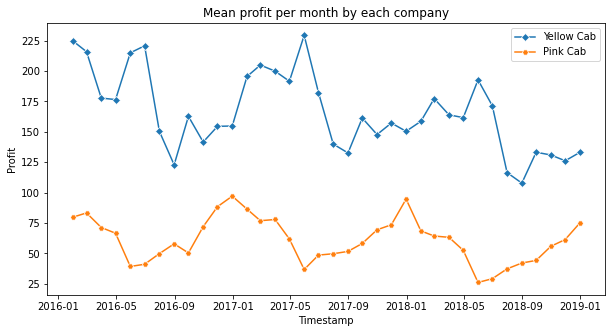

In [52]:
plt.figure(figsize = (10,5))
sns.lineplot(x=yellow_cab_profit_monthly.index, y='Profit', data=yellow_cab_profit_monthly, marker='D')
sns.lineplot(x=pink_cab_profit_monthly.index, y='Profit', data=pink_cab_profit_monthly, marker='H')
plt.legend(['Yellow Cab', 'Pink Cab'])
plt.title('Mean profit per month by each company')
plt.xlabel('Timestamp')
#plt.savefig('meanprofit_per_month.png')
plt.show()

In [53]:
import statsmodels.api as sm
y = yellow_cab_profit_monthly['Profit']
# graphs to show seasonal_decompose
def seasonal_decompose (y, name):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.savefig(name)
    plt.show()

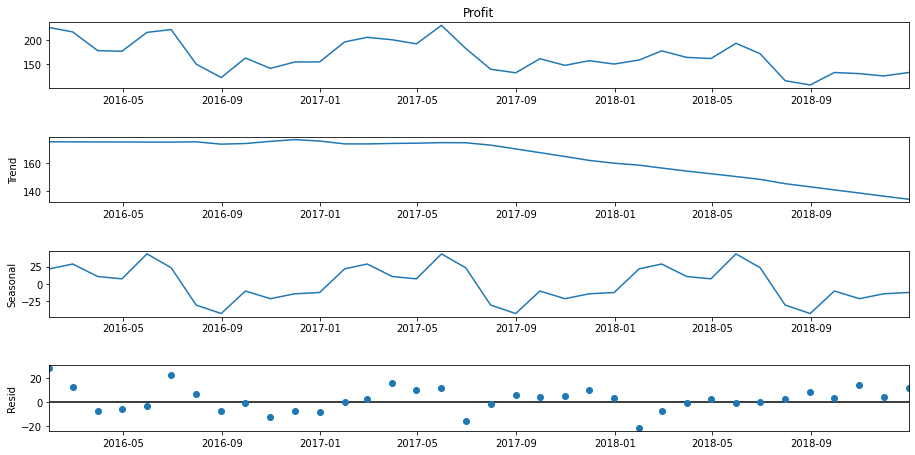

In [54]:
seasonal_decompose(y, 'seasonal_yellow_cab.png')

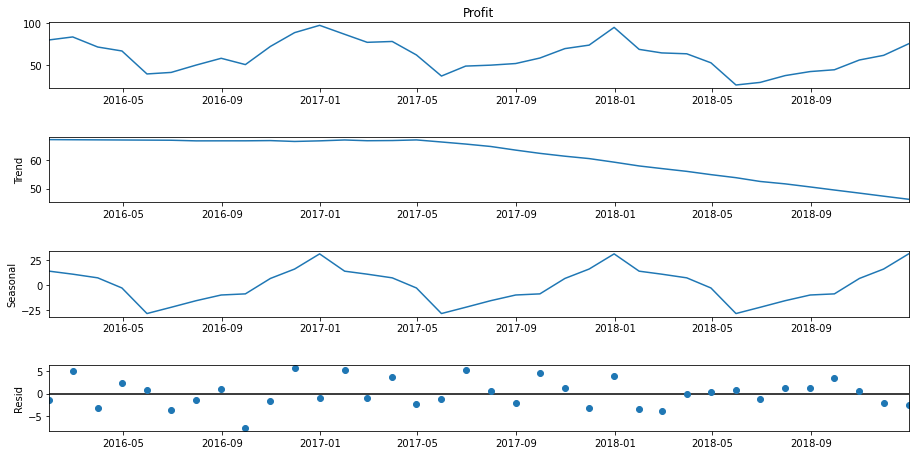

In [55]:
y2 = pink_cab_profit_monthly['Profit']
seasonal_decompose(y2, 'seasonal_pink_cab.png')

# Checking for Stationarity

In [56]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=7, min_periods=1).mean() 
    rolstd = pd.Series(timeseries).rolling(window=7, min_periods=1).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

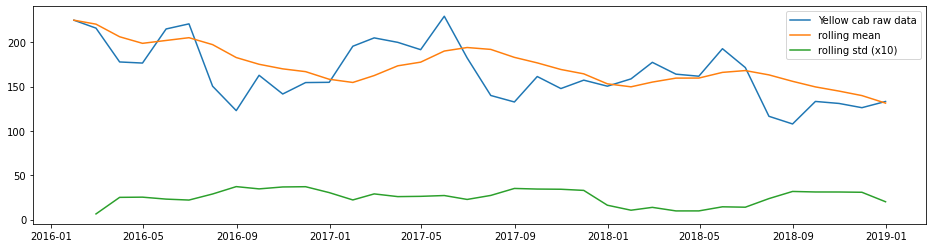

In [57]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'Yellow cab raw data')

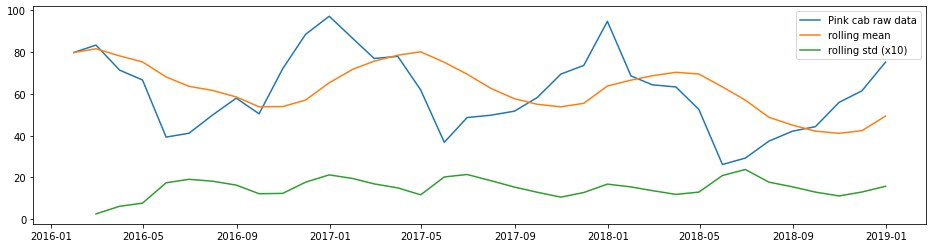

In [58]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y2,'Pink cab raw data')

In [59]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [60]:
ADF_test(y,'Yellow cab raw data')

 > Is the Yellow cab raw data stationary ?
Test statistic = 0.135
P-value = 0.968
Critical values :
	1%: -3.7238633119999998 - The data is not stationary with 99% confidence
	5%: -2.98648896 - The data is not stationary with 95% confidence
	10%: -2.6328004 - The data is not stationary with 90% confidence


In [61]:
ADF_test(y2,'Pink raw data')

 > Is the Pink raw data stationary ?
Test statistic = 1.067
P-value = 0.995
Critical values :
	1%: -3.6996079738860943 - The data is not stationary with 99% confidence
	5%: -2.9764303469999494 - The data is not stationary with 95% confidence
	10%: -2.627601001371742 - The data is not stationary with 90% confidence


### Conclusion: Both time series are not stationary

 > Is the de-trended data stationary ?
Test statistic = -5.504
P-value = 0.000
Critical values :
	1%: -3.8092091249999998 - The data is  stationary with 99% confidence
	5%: -3.0216450000000004 - The data is  stationary with 95% confidence
	10%: -2.6507125 - The data is  stationary with 90% confidence


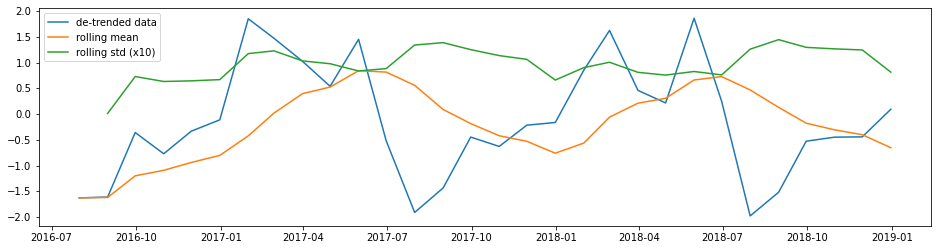

In [62]:
# Detrending
y_detrend =  (y - y.rolling(window=7).mean())/y.rolling(window=7).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the de-trended data stationary ?
Test statistic = -5.504
P-value = 0.000
Critical values :
	1%: -3.8092091249999998 - The data is  stationary with 99% confidence
	5%: -3.0216450000000004 - The data is  stationary with 95% confidence
	10%: -2.6507125 - The data is  stationary with 90% confidence


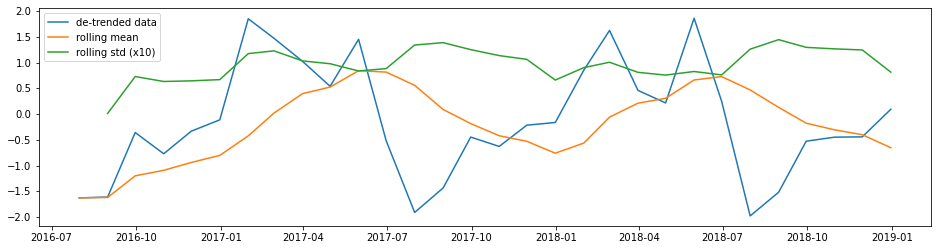

In [63]:
# Detrending
y2_detrend =  (y2 - y2.rolling(window=7).mean())/y2.rolling(window=7).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

In [73]:
train_size=int(len(y_detrend) *0.7) # 70% for training
test_size = int(len(y_detrend)) - train_size

train_y = y_detrend[:train_size].dropna()
test_y = y_detrend[train_size:].dropna()

In [80]:
def build_model(neurons):
  model = Sequential()
  model.add((LSTM(neurons, input_shape = (1,look_back), activation='tanh')))
  

  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return model

In [86]:
# Construct the Regressor model
regressor = KerasRegressor(build_fn = build_model,verbose=0)
parameters = {'batch_size': [10,15,20,50,100], 
              'epochs':[10,20,30,40],
              'neurons': [2,3,4,5],
              }
grid_search = GridSearchCV(estimator = regressor,
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 10)

In [ ]:
grid_search = grid_search.fit(x_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_